<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/ML%20deployment-%20AWS.SageMaker/Boston_House(AWS_SageMaker_Deploy_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWS SAGEMAKER 
Hello, I am [Vedant_Dave](vedantdave77@gmail.com), a data enthusiast with deep interest in machine learning and deep learning. 

## Intro To Topic
Today, I am going to deploy Boston Housing data Project using AWS Sagemaker's High level API called - "Python SDK". 
> This API has facility to train and deploy model in cloud directly from innner Jupyter notebook creation. So, I will use simple Machine learning workflow as usaual. 

> Data loading --> Data Preparation --> Model Training --> HP Tuning --> Deployment in AWS. (Hopefully, try to make Web Application). 

---
---

First of all, I will use SageMaker's batch transform feature, which  is a high-performance and high-throughput method for transforming data and generating inferences. 

- I personally think, It's ideal for scenarios where you're dealing with large batches of data, don't need sub-second latency, or need to both preprocess and transform the training data. 

- My main focus is to deploy model, so on analytic point of view, I tried to use Sagemaker's ML library and find median housing price for specific housing requrements in certain areas. 

 


## Set Environment (lib & SageMaker)

In [1]:
# Setting-up Notebook in relevant environment.

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_boston
import sklearn.model_selection

In [3]:
# set sagemaker in env.
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# Object to represent current active session of sagemaker - contains some useful info. for future usage.
session = sagemaker.Session()

# object shows IAM role - will help us to assign training job to sagemaker.
role = get_execution_role()

## Download Data 

In [4]:
# get data from sagemaker library
boston = load_boston()

## Data preparation and splitting.


In [7]:
# prepare data for python notebook
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
y_bos_pd = pd.DataFrame(boston.target)

# splitting into train and test
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X_bos_pd, y_bos_pd, test_size =0.33)

# further splitting of train to train(2/3) and validation(1/3)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.33)

## Uploading dataa files to S3.

Keep in mind that, 

- When a training job is constructed using SageMaker, a container is executed which performs the training operation.
- This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. 
- In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details, but first data saved locally and then uploaded to S3 container.




In [8]:
# define & ensure data dictionary...
data_dir = '.../data/boston'
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

In [10]:
# In data_dir, I amd creating csv file format for all data, and in validation and train set target data comes in first columns.

X_test.to_csv(os.path.join(data_dir,'test.csv'),header = False, index = False)
 
pd.concat([y_val,X_val], axis =1).to_csv(os.path.join(data_dir, 'validation.csv'),header=False, index= False)
pd.concat([y_train,X_train],axis =1).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False)

### Upload to S3 - data storage.
Its good prectice to give prefix to your S3 bucket, so you can easily get idea about specific container for relevant project. 
- Here, I am giving name as "dataset_name-algorithm_name-API_level".

I will use xgboost algorithm, which is one of the modern approach for supervised learning. It boost our algorithm gradient and give high accuracy result with good F1 score Matrix. 

> For more info, visit [XGBoost](https://xgboost.readthedocs.io/en/latest/) official documentation.

In [11]:
prefix = 'boston-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir,'test.csv'),key_prefix = prefix)
val_location = session.upload_data(os.path.join(data_dir,'validation.csv'), key_prefix = prefix)
train_location = session.upload_data(os.path.join(data_dir,'train.csv'),key_prefix = prefix)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


## Training XGBoost Model
There are two options for training model either use high-level API in which Sage-Maker will train algorithm ownself or from low level API inwhich we need to define our own work. 

I will go with both the cases to represent difference. Before this we must need some important information for sagemaker to give permissions and you can find them from [common_para_list](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)


In [13]:
# define container with uri to define container with session and ml-model info.
container = get_image_uri(session.boto_region_name,'xgboost')

# Now construct container object with requried parametrs.
xgb = sagemaker.estimator.Estimator(container,                                   # our training container
                                    role,                                       # defined IAM role for training
                                    train_instance_count=1,                     # instaces, depend how many you created - for lengthy job need more
                                    train_instance_type = 'ml.m4.xlarge',       # type of instace type for deployjent - can use m2 to m5 (AWS rate will according to that, check here --> https://aws.amazon.com/sagemaker/pricing/)
                                    output_path = 's3://{}/{}/output'.format(session.default_bucket(),prefix),   # output destination
                                    sagemaker_session=session)                  # current session (because instance are on regionwise servers, s3 bucket is globalize platform)

	get_image_uri(region, 'xgboost', '1.0-1').


> ***SageMaker has xgb HP tuning parameters as follow, you  can check it*** [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [16]:
# set HyperParameter of model.
xgb.set_hyperparameters(max_depth= 5,
                        etz = 0.2,
                        min_child_weight= 6,
                        subsample = 0.8,
                        objective = 'reg:linear',
                        early_stopping_round = 10,
                        num_round = 200)

In [17]:
# give some more info to sagemaker about our input's data structure and arrangement
s3_input_train = sagemaker.s3_input(s3_data= train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data= val_location, content_type='csv')

xgb.fit({'train':s3_input_train,'validation': s3_input_validation})

2020-06-06 07:07:45 Starting - Starting the training job...
2020-06-06 07:07:47 Starting - Launching requested ML instances......
2020-06-06 07:08:56 Starting - Preparing the instances for training......
2020-06-06 07:09:59 Downloading - Downloading input data...
2020-06-06 07:10:42 Training - Training image download completed. Training in progress..Arguments: train
[2020-06-06:07:10:42:INFO] Running standalone xgboost training.
[2020-06-06:07:10:42:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8480.23mb
[2020-06-06:07:10:42:INFO] Determined delimiter of CSV input is ','
[07:10:42] S3DistributionType set as FullyReplicated
[07:10:42] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-06:07:10:43:INFO] Determined delimiter of CSV input is ','
[07:10:42] S3DistributionType set as FullyReplicated
[07:10:43] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validatio


2020-06-06 07:10:54 Uploading - Uploading generated training model
2020-06-06 07:10:54 Completed - Training job completed
Training seconds: 55
Billable seconds: 55


---

**Attension:**
***Hello, I am from past,*** if you visited my notebook on batch-transform method then you see the testing model phase, but in case of deployment of model the scenario is changed

After deploying, I will test model in deployment environment and it helps us to get endpoint. - where we can get opportunity to give our own dataset outside of current dataset, menas you can apply your custom dataset by your own.

Simply, 

> **AWS[S3(DATA) + sagemaker(MODEL) -+- [{ENDPOINT(access_link)} ] -+- host_platform(WEB_APPLICATION)] - user**

Well, its use for application purpose. In app deployment we will see it further. 

---


## Deploy Model
Now that we have fit our model to the training data, and used the validation data to avoid overfitting, we can deploy our model and test it. Deploying is very simple when we use the high level API, we need only call the `deploy` method of our trained estimator

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.


In [19]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

### Use Model in deployed environment

In [22]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up as a numpy array.
y_pred = np.fromstring(y_pred, sep=',')

Our Output will give us result after execution, here we get output from endpoint. So, no need to save output in S3 or no need to save model for future purpose. 

## Ouput visualization (scatter plot)


Text(0.5, 1.0, 'Median Price vs Predicted Price')

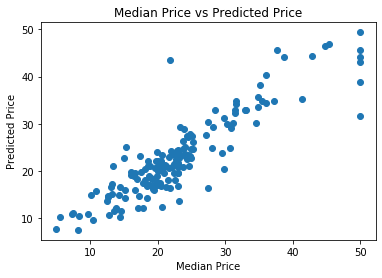

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

### Delete the endpoint
The end point is used to transfer output of model out of sagemaker, I mean from web app. But, if you are not going to deploy by web app then its ok, and better to delete it. Becuase, the sagemeaker is still running and give you a cost of sagemaker and S3. Here by running the following cell you will delete the endpoint. 

In [26]:
xgb_predictor.delete_endpoint()

### Important Observation:
The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. 

- You can do it from terminate notebook stance also.

***Keep in mind*, It will clear our all data.**


In [27]:
# remove all the files from data_dir
!rm $data_dir/*

# remove directory
!rmdir $data_dir

### Summary 
Let's revise 
The flow of notebook  ...
1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

Thats all, please visit [image_folder]() to see aws working screenshots.

In [28]:
# "Keep Learning, Enjoy Empowering" @dave117